In [56]:
import pandas as pd
import numpy as np
import re
from cleantext import clean
import torch
from transformers import TrainingArguments, Trainer, pipeline
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
import evaluate

In [57]:
test_data=pd.read_csv("./emotions_data/emotion-labels-test.csv")
train_data=pd.read_csv("./emotions_data/emotion-labels-train.csv")
val_data=pd.read_csv("./emotions_data/emotion-labels-val.csv")

In [58]:
data=pd.concat([test_data, train_data, val_data])


In [59]:
data.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [60]:
data["clean-text"]=data["text"].apply(lambda x: clean(x, no_emoji=True))

In [61]:
data["clean-text"]=data["clean-text"].apply(lambda x: re.sub('[^\w\s]',' ',x))

<Axes: xlabel='label'>

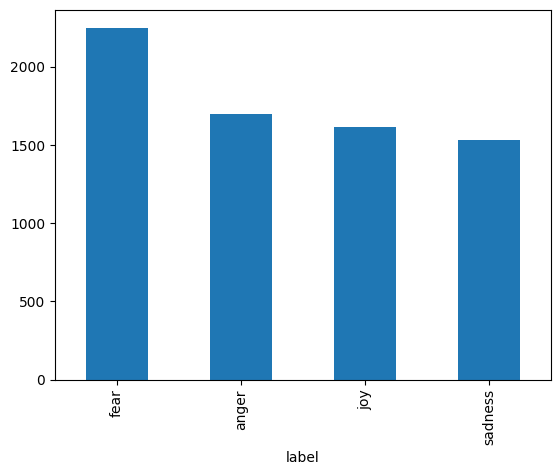

In [62]:
data["label"].value_counts().plot(kind="bar")

In [63]:
min_label=data.groupby("label").size().min()
data=data.groupby("label").apply(lambda x: x.sample(min_label)).reset_index(drop=True)

<Axes: xlabel='label'>

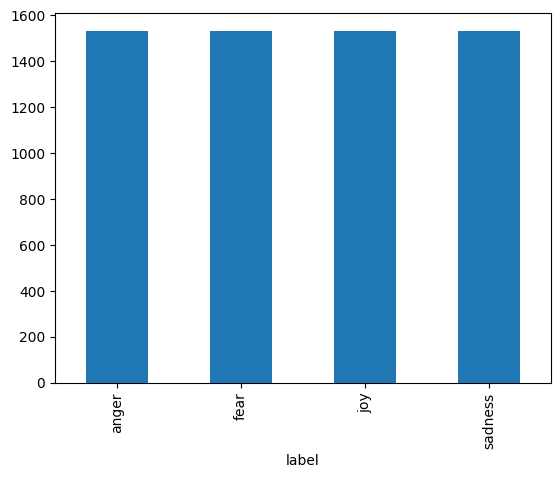

In [64]:
data["label"].value_counts().plot(kind="bar")

In [65]:
encode=LabelEncoder()

In [66]:
data["label-int"]=encode.fit_transform(data["label"])

In [67]:
data.head()

,text,label,clean-text,label-int
0,@BonesARP 'That is a disappointment.'\n\nHe fa...,anger,bonesarp that is a disappointment \nhe fake...,0
1,"#Forgiveness might make us look #weak, but the...",anger,forgivenessmight make us look weak but the ...,0
2,Oh daaaaaaamn @SophiaBush! #getitgirl #girlpow...,anger,oh daaaaaaamn sophiabush getitgirl girlpow...,0
3,.@Travelanswerman: B assured there is plenty o...,anger,travelanswerman b assured there is plenty o...,0
4,@CozanGaming that's what lisa asked before she...,anger,cozangaming that s what lisa asked before she...,0


In [68]:
train_data,test_data=train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data=train_test_split(train_data, test_size=0.1, random_state=42)


In [69]:
print(len(train_data)) 
print(len(test_data))
print(len(val_data))

4414
1227
491


In [70]:
train_df=pd.DataFrame({"text" : train_data["clean-text"], "label" : train_data["label-int"]})
test_df=pd.DataFrame({"text" : test_data["clean-text"], "label" : test_data["label-int"]})
val_df=pd.DataFrame({"text" : val_data["clean-text"], "label" : val_data["label-int"]})

In [71]:
from datasets import Dataset, DatasetDict

In [72]:
train_dataset=Dataset.from_dict(train_df)
test_dataset=Dataset.from_dict(test_df)
val_dataset=Dataset.from_dict(val_df)

In [73]:
final_dict=DatasetDict({'train': train_dataset,'test' : test_dataset, 'validation': val_dataset})
final_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1227
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 491
    })
})

In [74]:
tokenizer=XLNetTokenizer.from_pretrained("xlnet-base-cased")


In [75]:
def tokenization_function(example):
    return tokenizer(
        example["text"], padding='max_length',truncation=True, max_length=128)
    

In [76]:
tokenizer_set=final_dict.map(tokenization_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

In [77]:
sample_text=tokenizer_set["train"][0]["text"]
sample_text

' kelly_welles they were brilliant weren t they  made me feel v dull not having one  and why no tattoo emoji  this ll have to do    x'

In [78]:
print(tokenizer_set["train"][0]["input_ids"])
print(tokenizer_set["train"][0]["token_type_ids"])
print(tokenizer_set["train"][0]["attention_mask"])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 7617, 111, 2732, 2297, 202, 63, 55, 7142, 4363, 17, 46, 63, 140, 110, 567, 2721, 12692, 50, 491, 65, 21, 611, 116, 10784, 17, 16465, 2030, 52, 17, 215, 47, 22, 112, 3512, 4, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [79]:
small_train_dataset=tokenizer_set["train"].shuffle(seed=42).select(range(100))
small_eval_dataset=tokenizer_set["test"].shuffle(seed=42).select(range(100))

In [80]:
print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})


In [81]:
from transformers import XLNetForSequenceClassification
model=XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                        num_labels=4,
                                                        id2label={0:"fear",1:"anger",
                                                                  2:"joy",3:"sadness"},
                                                    label2id={"fear": 0, "anger": 1, "joy": 2, "sadness": 3})


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
import evaluate
metric=evaluate.load("accuracy")

In [83]:
import numpy as np
def compute_pred(eval_pred):
    logits,labels=eval_pred
    predictions=np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [84]:
from transformers import TrainingArguments
trainee=TrainingArguments(output_dir="./fresh_xlnet_base_model",
                          evaluation_strategy="epoch",
                          num_train_epochs=3)

C:\Users\Maryam Rauf\anaconda3\envs\llms_course_env\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [85]:
from transformers import Trainer
trainer=Trainer(
    model=model,
    args=trainee,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_pred)

In [86]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.522520,0.190000
2,No log,1.429322,0.190000
3,No log,1.428374,0.190000


TrainOutput(global_step=39, training_loss=1.419647705860627, metrics={'train_runtime': 966.7787, 'train_samples_per_second': 0.31, 'train_steps_per_second': 0.04, 'total_flos': 21366375321600.0, 'train_loss': 1.419647705860627, 'epoch': 3.0})

In [87]:
trainer.evaluate()

{'eval_loss': 1.4283742904663086,
 'eval_accuracy': 0.19,
 'eval_runtime': 75.7486,
 'eval_samples_per_second': 1.32,
 'eval_steps_per_second': 0.172,
 'epoch': 3.0}

In [89]:
model.save_pretrained("my_finetuned_model", safe_serialization=False)


In [90]:
fine_tuned_model=XLNetForSequenceClassification.from_pretrained("my_finetuned_model")


In [91]:
from transformers import pipeline
clf=pipeline(task="text-classification",
    model=fine_tuned_model,
    tokenizer=tokenizer    ) 

Device set to use cpu


In [94]:
clf("This is a random test sentence", top_k=None)


[{'label': 'joy', 'score': 0.4972976744174957},
 {'label': 'sadness', 'score': 0.27574533224105835},
 {'label': 'fear', 'score': 0.11984565109014511},
 {'label': 'anger', 'score': 0.10711130499839783}]